# Step 1: Setting the environment

In [328]:
# Import required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, decomposition
from scipy import stats
import statsmodels.api as sm

In [329]:
# Clean VCF

vcf_path = f"data/genotypes.vcf"
ann_path = f"data/annotations.txt"

# Get headers
with open(vcf_path, "r") as f:
    for line in f:
        if line.startswith("#CHROM"):
            header = line.strip().lstrip("#").split("\t")
            break

# Load VCF
vcf_df = pd.read_csv(
    vcf_path,
    sep="\t",
    comment="#",
    header=None,
    names=header,
    low_memory=False
)

# Non-sample columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]

# Sample columns (all individuals)
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Remove everything except the first item before ':'
for col in sample_cols:
    vcf_df[col] = vcf_df[col].astype(str).str.split(":").str[0]

## 1a. Exploratory data analysis

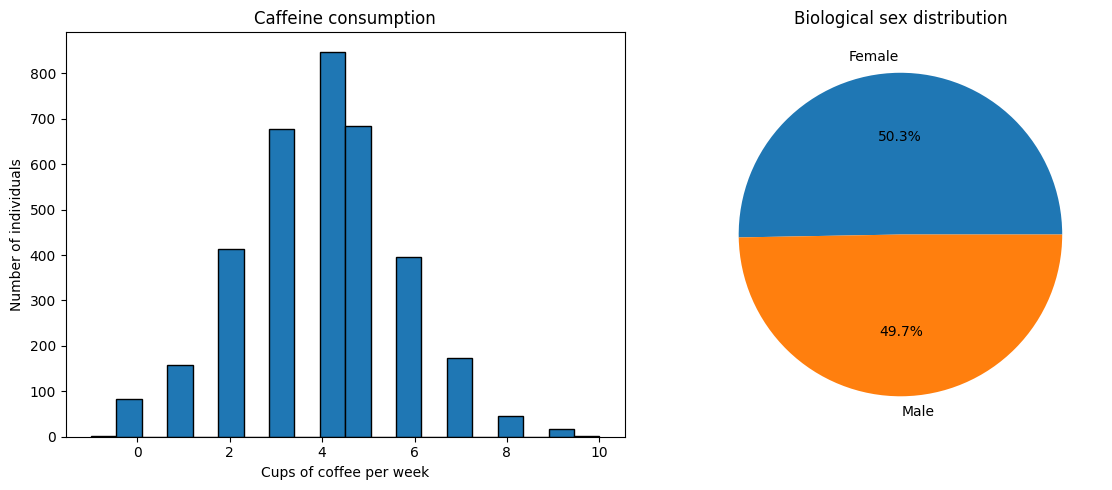

In [330]:
# Plot histogram of caffeine consumption and pie chart for distribution of biological sex

annotations = pd.read_csv(ann_path, sep="\t")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Histogram of caffeine consumption
axes[0].hist(annotations["CaffeineConsumption"], bins=20, edgecolor="black")
axes[0].set_xlabel("Cups of coffee per week")
axes[0].set_ylabel("Number of individuals")
axes[0].set_title("Caffeine consumption")

# Right: pie chart with Male/Female labels
sex_counts = annotations["isFemale"].value_counts()

axes[1].pie(
    sex_counts,
    labels=[("Female" if str(x).lower() == "true" else "Male") for x in sex_counts.index],
    autopct="%1.1f%%"
)
axes[1].set_title("Biological sex distribution")

plt.tight_layout()
plt.show()

# Step 2: SNP-level filtering - call rate

## 2a. Calculate call rate for each SNP and plot histogram of call rates

In [331]:
# Calculate call rate for each SNP

#Identify sample genotype columns
fixed_cols = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
sample_cols = [col for col in vcf_df.columns if col not in fixed_cols]

# Compute call rate
is_called = (vcf_df[sample_cols] != "./.")
call_rate = is_called.sum(axis=1) / len(sample_cols)
vcf_df = vcf_df.copy()
vcf_df["call_rate"] = call_rate

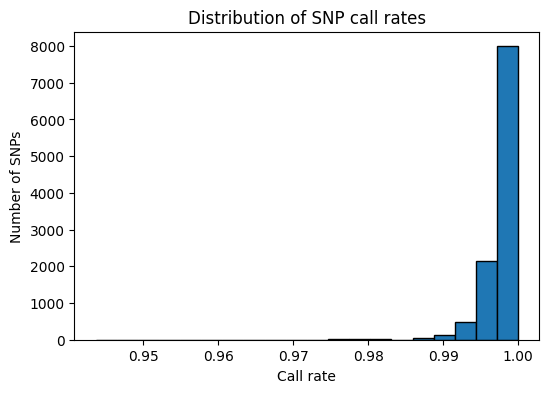

In [332]:
# Plot histogram of call rates

plt.figure(figsize=(6,4))
plt.hist(call_rate, bins=20, edgecolor="black")
plt.xlabel("Call rate")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP call rates")
plt.show()

In [333]:
# Keep variants with call rate = 1.0

vcf_filtered = vcf_df[vcf_df["call_rate"] == 1.0]
num_removed = len(vcf_df) - len(vcf_filtered)
print("Number of removed variants due to incomplete data: " + str(num_removed))

Number of removed variants due to incomplete data: 2888


# Step 3: SNP-level filtering - minor allele frequency (MAF)

## 3a. Calculate MAF for each SNP and plot histogram of MAFs for all SNPs

In [334]:
def gt_to_num(gt):
    if gt == "0/0":
        return 0
    elif gt in ["0/1", "1/0"]:
        return 1
    elif gt == "1/1":
        return 2
    else:
        return np.nan

In [335]:
# Calculate MAF for each SNP

# Convert GT to numeric
geno_numeric = vcf_filtered[sample_cols].map(gt_to_num)

# Allele frequency
allele_count = geno_numeric.sum(axis=1)
called = geno_numeric.notna().sum(axis=1)
allele_total = 2 * called
freq = allele_count / allele_total

# Minor allele frequency
maf = np.where(freq <= 0.5, freq, 1 - freq)
vcf_filtered = vcf_filtered.copy()
vcf_filtered["MAF"] = maf

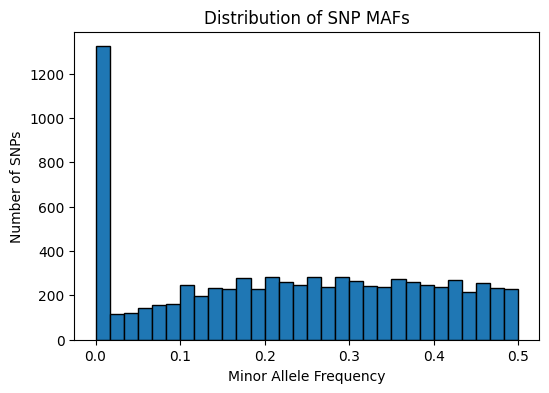

In [336]:
# Plot histogram of all MAFs for all SNPs

plt.figure(figsize=(6,4))
plt.hist(maf, bins=30, edgecolor="black")
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Number of SNPs")
plt.title("Distribution of SNP MAFs")
plt.show()

In [337]:
# Remove variants whose MAF <= 5%

vcf_maf_filtered = vcf_filtered[maf > 0.05]
geno_numeric_filtered = vcf_maf_filtered[sample_cols].map(gt_to_num)
num_removed_maf = len(vcf_filtered) - len(vcf_maf_filtered)
print("Number of removed variants due to low MAF: " + str(num_removed_maf))


Number of removed variants due to low MAF: 1559


## TODO: Provide an interpretation for the shape of the MAF histogram. 

# Step 4: GWAS on the full study cohort

## 4a: Explore potential effect of biological sex on caffeine consumption


### i. Plot boxplot and density plot showing distribution of caffeine consumption by biological sex

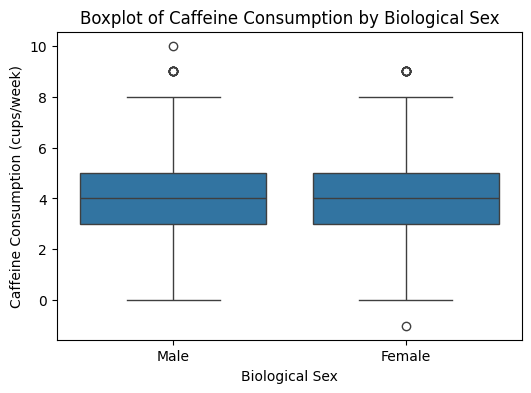

In [338]:
# Plot boxplot

plt.figure(figsize=(6,4))
sns.boxplot(
    data=annotations,
    x="isFemale",
    y="CaffeineConsumption"
)
plt.xticks([0,1], ["Male", "Female"])
plt.xlabel("Biological Sex")
plt.ylabel("Caffeine Consumption (cups/week)")
plt.title("Boxplot of Caffeine Consumption by Biological Sex")
plt.show()

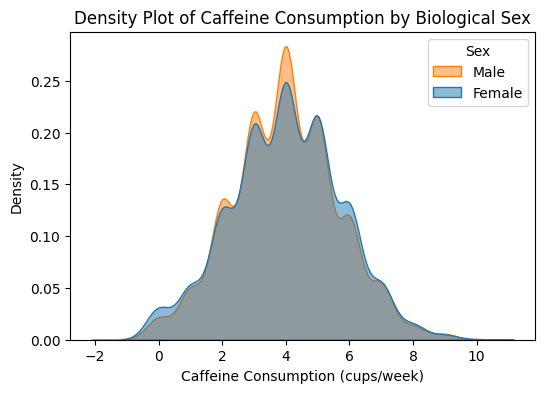

In [339]:
# Plot density plot

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.legend(title="Sex", labels=["Male", "Female"])
plt.xlabel("Caffeine Consumption (cups/week)")
plt.title("Density Plot of Caffeine Consumption by Biological Sex")
plt.show()

### ii. Use linear regression to test relationship between caffeine consumption and biological sex

In [340]:
# Linear regression

ann_df = annotations[["CaffeineConsumption", "isFemale"]].dropna()
caffeine_sex_X = ann_df["isFemale"].map({True: 1, False: 0})
caffeine_sex_y = ann_df["CaffeineConsumption"]

# Add constant for intercept
caffeine_sex_X = sm.add_constant(caffeine_sex_X)

# Fit OLS regression
caffeine_sex_model = sm.OLS(caffeine_sex_y, caffeine_sex_X).fit()

# Show regression summary
# print(lr_model.summary())
print("Intercept coefficient: " + str(round(caffeine_sex_model.params.const, 3)))
print("Slope coefficient: " + str(round(caffeine_sex_model.params.isFemale, 3)))
print("R^2: " + str(caffeine_sex_model.rsquared))
print("p-value: " + str(round(caffeine_sex_model.pvalues.isFemale, 3)))

Intercept coefficient: 3.992
Slope coefficient: -0.015
R^2: 1.8596649948521282e-05
p-value: 0.799


We should not include biological sex as a covariate in our analysis because it has virtually no effect on caffeine consumption, given the very low R^2 value and high p-value.

## 4b. Population structure

### i. Calculate principal components of genotype matrix and plot 1st and 2nd PCs

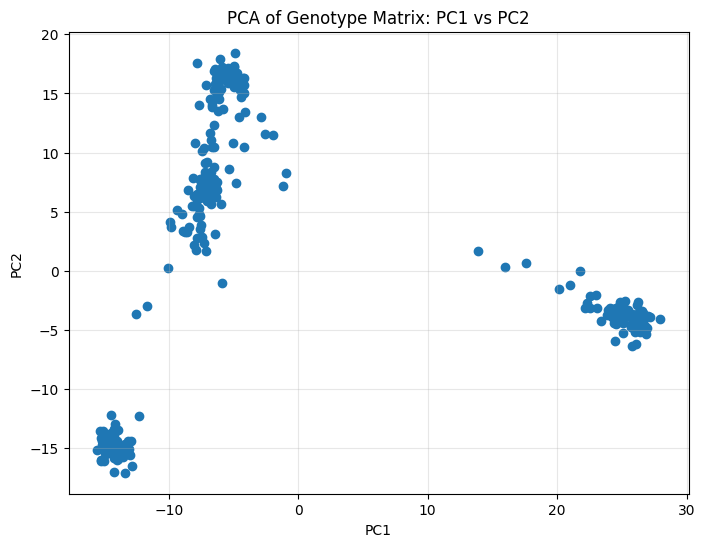

In [341]:
pca = decomposition.PCA(n_components=2)
pcs = pca.fit_transform(geno_numeric_filtered.transpose())
pc_df = pd.DataFrame({
    'PC1': pcs[:, 0],
    'PC2': pcs[:,1]
})

plt.figure(figsize=(8,6))
plt.scatter(pc_df['PC1'], pc_df['PC2'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix: PC1 vs PC2")
plt.grid(alpha=0.3)
plt.show()

### ii. Number of data clusters

We can observe 3 data clusters with PC1 and PC2. They represent groups of individuals from different superpopulations, due to differences in allele frequencies across ancestries. We should correct for population structure because ancestry could be a confounding factor in further GWAS.

## 4c. Run GWAS without covariate correction

### i. Use linear regression to test association between SNPs and caffeine consumption

### ii. Extract coefficient of association and p-value for each SNP

In [342]:
ann_df = annotations[["Sample", "CaffeineConsumption"]].dropna()
ann_df = ann_df.set_index("Sample")
no_correction_y = ann_df["CaffeineConsumption"]

no_correction_betas = []
no_correction_pvals = []

snps = geno_numeric_filtered.transpose().columns.tolist()
for snp in snps:
    no_correction_x = geno_numeric_filtered.transpose()[snp]
    tmp_df = pd.DataFrame({'y': no_correction_y, 'x': no_correction_x}).dropna()
    
    if tmp_df['x'].nunique() < 2:
        no_correction_betas.append(np.nan)
        no_correction_pvals.append(np.nan)
        continue
    
    no_correction_X = sm.add_constant(tmp_df['x'])
    no_correction_model = sm.OLS(tmp_df['y'], no_correction_X).fit()

    no_correction_betas.append(no_correction_model.params['x'])
    no_correction_pvals.append(no_correction_model.pvalues['x'])

no_correction_results = pd.DataFrame({
    'SNP': snps,
    'beta': no_correction_betas,
    'pval': no_correction_pvals
}).set_index("SNP")

## 4d. Produce a Manhattan plot

### i. Produce scatterplot with variant's linear position on x-axis and significance of association on y-axis

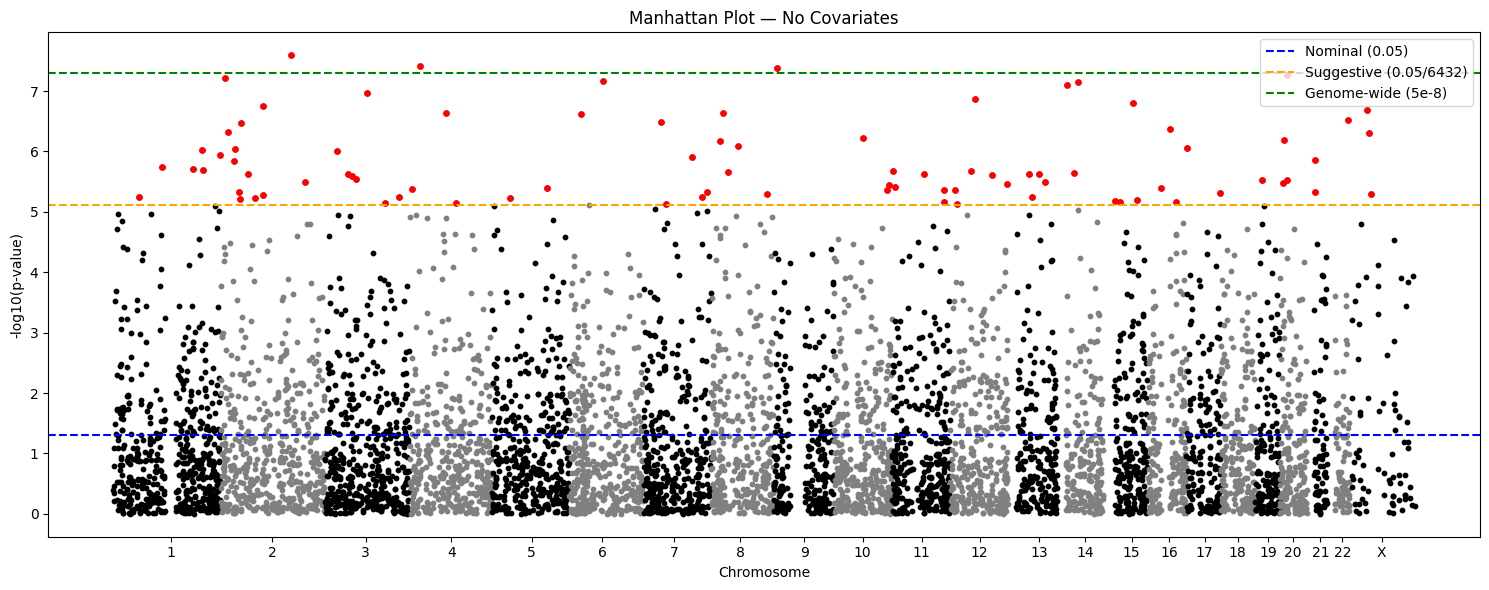

In [343]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = no_correction_results['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — No Covariates")
plt.legend()
plt.tight_layout()
plt.show()

### ii. How many SNPs pass each threshold? Explain the results

In [344]:
n_nominal = (df["pval"] < p_nominal).sum()
n_suggestive = (df["pval"] < p_suggestive).sum()
n_genomewide = (df["pval"] < p_genomewide).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 2109
SNPs passing suggestive (p < 0.05/N): 86
SNPs passing genome-wide (p < 5e-8): 3


**Nominal significance:**
    Under the null hypothesis, we expect around 5% of SNPS (around 320) to be nominally significant by chance alone. But we observed 2109, which is over 6 times more than expected. The fact that many more SNPs than expected pass the nominal threshold suggests that the phenotype may be influenced by many genetic variants, or that random variation is producing more significant results than expected. It indicates that nominal significance alone is not reliable when testing thousands of SNPs.

**Suggestive threshold:**
    SNPs that pass the suggestive threshold show stronger evidence of association than expected by chance alone. These signals are still not definitive, but they represent the most promising loci that might be worth investigating further.

**Genome-wide significance:**
    Three SNPs meet the conventional genome-wide significance threshold. These variants show very strong statistical evidence of association with caffeine consumption, strong enough that they would be considered credible candidate SNPs in a typical GWAS.

## 4e. Repeat GWAS and Manhattan plot, correcting for covariates based on top 10 PCs

In [345]:
# PCA with 10 components
geno_df_for_pca = geno_numeric_filtered.transpose()
ann_df_for_pca = annotations.set_index("Sample")
ann_sub = ann_df_for_pca.loc[geno_df_for_pca.index]

pca10 = decomposition.PCA(n_components=10, svd_solver="full", random_state=0)
pcs10 = pca10.fit_transform(geno_df_for_pca)
pc_10df = pd.DataFrame(
    pcs10,
    columns=[f"PC{i}" for i in range(1, 11)]
)
pc_10df.insert(0, "Sample", ann_sub.index.values)
pc_10df = pc_10df.set_index("Sample")

In [346]:
# Perform GWAS

df = ann_sub.join(pc_10df).join(geno_df_for_pca)

snp_cols = geno_df_for_pca.columns  # all SNP names
betas = []
pvals = []
snps = []

for snp in snp_cols:

    temp = df[[snp, "CaffeineConsumption"] + [f"PC{i}" for i in range(1,11)]].dropna()

    # Skip monomorphic SNPs
    if temp[snp].nunique() < 2:
        betas.append(np.nan)
        pvals.append(np.nan)
        snps.append(snp)
        continue

    y = temp["CaffeineConsumption"]
    X = temp[[snp] + [f"PC{i}" for i in range(1,11)]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    betas.append(model.params[snp])
    pvals.append(model.pvalues[snp])
    snps.append(snp)

gwas_pc = pd.DataFrame({
    "SNP": snps,
    "beta": betas,
    "pval": pvals
}).set_index("SNP")

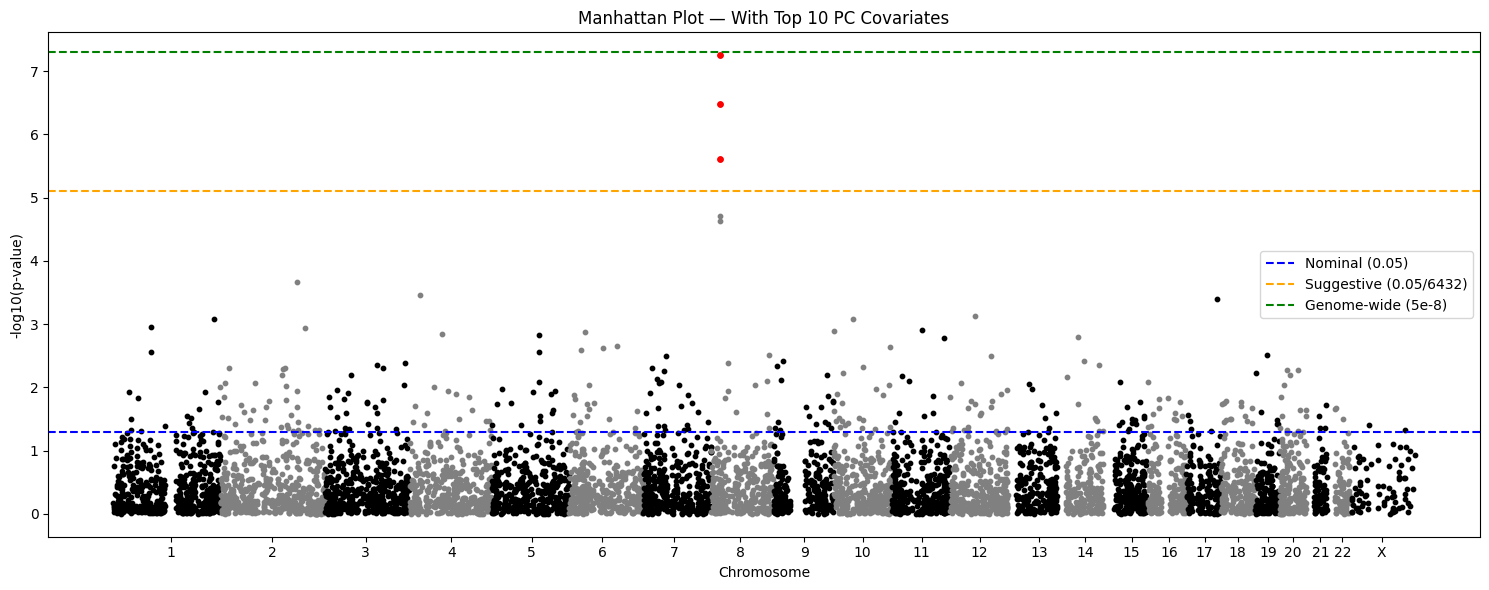

In [347]:
pos = vcf_maf_filtered[['CHROM', 'POS']]
pval = gwas_pc['pval']
df = pd.merge(pos, pval, left_index=True, right_index=True)

# Convert chromosome labels to numeric ordering
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["CHROM"] = pd.Categorical(df["CHROM"], categories=chrom_order, ordered=True)
df = df.sort_values(["CHROM", "POS"])

# Add -log10(p) and cumulative positions
df['neglog10p'] = -np.log10(df['pval'])
chrom_sizes = df.groupby('CHROM', observed=True)['POS'].max()
chrom_start = chrom_sizes.cumsum() - chrom_sizes
chrom_start = chrom_start.to_dict()
df["pos_cum"] = df.apply(lambda row: row["POS"] + chrom_start[row["CHROM"]], axis=1)

# Significance thresholds
N = df.shape[0]
p_nominal = 0.05
p_suggestive = 0.05 / N
p_genomewide = 5e-8
thr_nominal = -np.log10(p_nominal)
thr_suggestive = -np.log10(p_suggestive)
thr_genomewide = -np.log10(p_genomewide)

# Manhattan plot
plt.figure(figsize=(15,6))

# Alternating colors by chromosome
colors = ["black", "gray"]
chroms = [c for c in chrom_order if c in df["CHROM"].unique()]

for i, chrom in enumerate(chroms):
    subset = df[df["CHROM"] == chrom]
    plt.scatter(
        subset["pos_cum"],
        subset["neglog10p"],
        s=10,
        color=colors[i % 2]
    )

# Highlight suggestive SNPs
sig_mask = df["pval"] < p_suggestive
plt.scatter(
    df[sig_mask]["pos_cum"],
    df[sig_mask]["neglog10p"],
    s=15,
    color="red"
)

# Threshold lines
plt.axhline(thr_nominal, color="blue", linestyle="--", label="Nominal (0.05)")
plt.axhline(thr_suggestive, color="orange", linestyle="--", label=f"Suggestive (0.05/{N})")
plt.axhline(thr_genomewide, color="green", linestyle="--", label="Genome-wide (5e-8)")

# X-axis ticks at chromosome midpoints
chrom_mid = df.groupby("CHROM", observed=True)["pos_cum"].mean()
plt.xticks(chrom_mid.values, chrom_mid.index)

plt.xlabel("Chromosome")
plt.ylabel("-log10(p-value)")
plt.title("Manhattan Plot — With Top 10 PC Covariates")
plt.legend()
plt.tight_layout()
plt.show()

In [348]:
N = gwas_pc.shape[0]
n_nominal = (gwas_pc["pval"] < 0.05).sum()
n_suggestive = (gwas_pc["pval"] < 0.05 / N).sum()
n_genomewide = (gwas_pc["pval"] < 5e-8).sum()

print("SNPs passing nominal (p < 0.05):", n_nominal)
print("SNPs passing suggestive (p < 0.05/N):", n_suggestive)
print("SNPs passing genome-wide (p < 5e-8):", n_genomewide)

SNPs passing nominal (p < 0.05): 310
SNPs passing suggestive (p < 0.05/N): 3
SNPs passing genome-wide (p < 5e-8): 0


### i. How does correcting for the top 10 PCs change the results?

After including the top 10 PCs as covariates, the number of significant SNPs decreased by a lot, and all genome-wide significant associations disappeared. This shows that many apparent SNP associations in the uncorrected analysis were driven by population structure rather than true genetic relationships to caffeine consumption.

### ii. Report the p-value and Beta for the most significant SNP

In [349]:
best = gwas_pc.loc[gwas_pc["pval"].idxmin()]
print("Most significant SNP (PC corrected):")
print(best)

Most significant SNP (PC corrected):
beta    8.045174e-01
pval    5.588198e-08
Name: 5112, dtype: float64
